In [1]:
#NN Surrogate model class
import injector_surrogate_quads
from injector_surrogate_quads import *
import physics_gp

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import gpytorch
import botorch 

import matplotlib.pyplot as plt

# BO for Minimizing Emittance*Bmag with 9 Variables (SQ, CQ, SOL, matching quads)

In [2]:
#load injector model
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

2022-06-28 17:58:58.815996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import design Twiss parameters (OTR2)

In [3]:
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
print(twiss0['x'])
print(twiss0['y'])

[1e-06, 1.113081026, -0.0689403587]
[1e-06, 1.113021659, -0.07029489754]


## Objective Function

In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(config): 
    """
    D is input space dimensionality
    :param config: input values of opt_var_names, torch.tensor, shape (1, D) 
    """
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around which to optimize
    x_in[:,:] = np.asarray(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    for i in range(config.size(dim=0)):
        x_in[:, Model.loc_in[opt_var_names[i]]] = config[i]

    #output predictions
    y_out = Model.pred_machine_units(x_in) 

    return -1*objective(y_out)[0]


def objective(y_out):
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:, Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:, Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = np.sqrt(out1 * out2)
  
    sigma_x = y_out[:, Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:, Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x, alpha_y = alpha0_x, alpha0_y
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * np.sqrt(beta0_x / beta_x) - alpha0_x * np.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * np.sqrt(beta0_y / beta_y) - alpha0_y * np.sqrt(beta_y / beta0_y))**2)
    bmag = np.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

## Gaussian Regression & Acquisition Function

In [5]:
def get_BO_point(x, f, bounds, beta=2.5, mean_module=None, input_transform=None, outcome_transform=None, precision = None, phys=False):
    """
    function that trains a GP model of data and returns the next observation point using UCB
    D is input space dimensionality
    N is number of samples

    :param x: input points data, torch.tensor, shape (N,D)
    :param f: output point data, torch.tensor, shape (N,1)
    :param bounds: input space bounds, torch.tensor, shape (2,D)
    :param precision: precision matrix used for RBF kernel (must be PSD), torch.tensor, (D,D)
    :param beta: UCB optimization parameter, float
    :return x_candidate, model: next observation point and gp model w/observations
    """
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    if phys == True:
        gp = physics_gp.PhysicsExactGPModel(x, f.flatten(), likelihood, precision)
    else:
        gp = botorch.models.SingleTaskGP(x, f, likelihood=likelihood, 
                                         mean_module=mean_module, 
                                         outcome_transform=outcome_transform, 
                                         input_transform=input_transform)
        
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gp.likelihood, gp)
    
    # fit GP hyperparameters
    botorch.fit.fit_gpytorch_model(mll)

    # do UCB acquisition
    UCB = botorch.acquisition.UpperConfidenceBound(gp, beta=beta)
    candidate, acq_value = botorch.optim.optimize_acqf(UCB,
                                                       bounds=bounds,
                                                       q=1,
                                                       num_restarts=20,
                                                       raw_samples=20)
    return candidate, gp

## Set up initial training samples

In [6]:
#create initial samples within specified bounds
n_samples = 3
n_var = 9

train_x = torch.zeros((n_samples, n_var)) 
for i in range(n_var):
    train_x[:,i] = torch.as_tensor(np.random.uniform(bounds[i,0],bounds[i,1],(n_samples,)))
print(train_x)

train_y = torch.tensor([evaluate(vars) for vars in train_x]).reshape(-1,1)
print(train_y)

#transformer 
transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
transformer_y = botorch.models.transforms.outcome.Standardize(1)

normed_bounds = torch.cat((torch.zeros(1,n_var), torch.ones(1,n_var)), 0)

tensor([[ 4.7353e-01,  1.4180e-03,  1.1853e-03, -1.8333e+00,  3.9729e+00,
         -6.3369e+00,  3.6304e+00, -7.0999e-01, -2.3451e+00],
        [ 4.6241e-01,  1.8447e-02,  3.1129e-03, -2.2787e+00,  2.7344e+00,
         -1.3687e+00,  5.2391e+00,  3.2559e+00, -1.8493e+00],
        [ 4.6268e-01, -2.2117e-04,  5.8623e-03, -1.9962e+00,  3.8787e+00,
         -1.3704e+00, -5.3115e-01,  6.9460e+00, -2.0690e+00]])
tensor([[ -1.6260],
        [-11.7012],
        [ -1.3197]], dtype=torch.float64)


2022-06-28 17:58:59.448726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-28 17:58:59.452086: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996350000 Hz


## Bayesian Optimization

In [7]:
def BayesianOptimization(train_x, train_y, n_steps, prior = None, phys = False):
    best_y_list = []
    best_y = torch.max(train_y)
    best_y_list.append(best_y)
    
    if (prior == None):
        transformer_y = botorch.models.transforms.outcome.Standardize(1)
    else:
        transformer_y = botorch.models.transforms.outcome.Standardize(1)

    for i in range(n_steps):
        x_new, model = get_BO_point(train_x, train_y, 
                                    bounds=bounds.transpose(0,1), 
                                    mean_module=prior, 
                                    input_transform=transformer_x, 
                                    outcome_transform=transformer_y, 
                                    phys=phys)

        train_x = torch.cat((train_x, x_new))
        new_y = torch.tensor(evaluate(train_x[-1])).reshape(1,1)
        train_y = torch.cat((train_y, new_y))

        if (new_y > best_y):
            best_y = new_y
            color = '\033[95m', '\033[0m'
        else: 
            color = '\u001b[30m', '\033[0m'
        
        best_y_list.append(best_y)
        
        print("iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4")
        print(f'{color[0]}{i+1}      {train_y[-1,0]:.5f}   {train_x[-1,0]:.5f}   {train_x[-1,1]:.5f}   {train_x[-1,2]:.5f}   {train_x[-1,3]:.5f}   {train_x[-1,4]:.5f}   {train_x[-1,5]:.5f}   {train_x[-1,6]:.5f}   {train_x[-1,7]:.5f}   {train_x[-1,8]:.5f}{color[1]}')
        
    return np.array(best_y_list, dtype=object)

In [8]:
# constant prior mean
# constant_prior_best_y = BayesianOptimization(train_x, train_y, 30, prior = None, phys = False) 

### use NN as prior mean

In [9]:
# model 
import torch.nn as nn
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 20
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

# create prior mean
from gpytorch.means.mean import Mean
class CustomMean(Mean):
    def __init__(self, name):
        super(CustomMean, self).__init__()
        self.NN_model = NN_prior()
        self.NN_model.load_state_dict(torch.load('./results/' + name + '.pth'))
        self.NN_model.eval()
    
    def forward(self, x):
        m = self.NN_model(x)
        return m.squeeze()

In [10]:
NN_prior_mean = CustomMean('model_1hidden_20nodes_500epoch_0.02')
print(NN_prior_mean)
NN_prior_best_y = BayesianOptimization(train_x, train_y, 10, prior = NN_prior_mean, phys = False)

CustomMean(
  (NN_model): NN_prior(
    (network): Sequential(
      (0): Linear(in_features=9, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Tanh()
      (4): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)
iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4
1      -4.35770   0.48500   -0.01703   -0.01723   -4.00000   1.00382   -5.87637   -0.99864   1.35290   -7.00000
iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4
2      -7.15446   0.46000   -0.02000   -0.02000   -4.00000   1.34466   -7.00000   -1.00000   -1.00000   -7.00000
iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4
3      -6.20182   0.46000   0.02000   0.02000   -1.35160   4.00000   -7.00000   7.00000   -1.00000   -3.94576
iter     target       SOL        CQ        SQ 

iter 0
iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4
1      -1.69016   0.46602   -0.01572   0.00677   -1.49224   4.00000   -2.33247   -1.00000   7.00000   -2.22893
iter     target       SOL        CQ        SQ        QA1        QA2        Q1        Q2        Q3        Q4
1      -3.48161   0.46000   -0.02000   -0.00702   -1.88063   2.32146   -1.00000   1.36410   2.09886   -7.00000


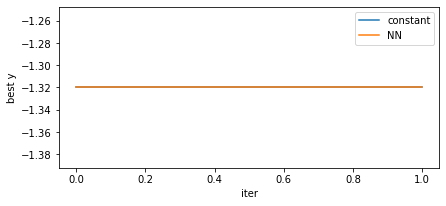

In [11]:
plt.gcf().set_size_inches(15,35)
for i in range(1):
    print(f'iter {i}')
    constant_prior_best_y = BayesianOptimization(train_x, train_y, 1, prior = None, phys = False) 
    NN_prior_best_y = BayesianOptimization(train_x, train_y, 1, prior = NN_prior_mean, phys = False)
    plt.subplot(10,2,i+1)
    plt.xlabel('iter')
    plt.ylabel('best y')
    plt.plot(constant_prior_best_y, label = "constant")
    plt.plot(NN_prior_best_y, label = "NN")
    plt.legend()

plt.show()

In [12]:
"""
#define acquisition function
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf

#optimize
n_steps = 45
for i in range(n_steps):
    #best_normed_y = torch.max(normed_train_y)
    UCB = UpperConfidenceBound(gp, beta=2.5)
    #EI = ExpectedImprovement(gp, best_normed_y)

    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)
    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)

    train_x = torch.cat((train_x, transformer_x.backward(candidate)))
    normed_train_x = transformer_x.forward(train_x)

    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)
    train_y = torch.cat((train_y, new_y))
    
    print("iteration        target         varx         vary         varz")
    print(f'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-1][2]:.5f}')
    print(torch.max(train_y))
    
    transformer_y = transformer.Transformer(train_y, 'standardize')
    normed_train_y = transformer_y.forward(train_y)

    gp = SingleTaskGP(normed_train_x, normed_train_y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll);
"""

'\n#define acquisition function\nfrom botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement\nfrom botorch.optim import optimize_acqf\n\n#optimize\nn_steps = 45\nfor i in range(n_steps):\n    #best_normed_y = torch.max(normed_train_y)\n    UCB = UpperConfidenceBound(gp, beta=2.5)\n    #EI = ExpectedImprovement(gp, best_normed_y)\n\n    bounds = torch.cat((torch.zeros(1,3), torch.ones(1,3)), 0)\n    candidate, acq_value = optimize_acqf(UCB, bounds = bounds, num_restarts = 20, q = 1, raw_samples = 20)\n\n    train_x = torch.cat((train_x, transformer_x.backward(candidate)))\n    normed_train_x = transformer_x.forward(train_x)\n\n    new_y = torch.tensor(evaluate(train_x[-1][0], train_x[-1][1], train_x[-1][2])).reshape(1,1)\n    train_y = torch.cat((train_y, new_y))\n    \n    print("iteration        target         varx         vary         varz")\n    print(f\'{i+1}              {train_y[-1][0]:.5f}      {train_x[-1][0]:.5f}      {train_x[-1][1]:.5f}      {train_x[-